In [1]:
import pandas as pd
import nltk
import gensim

df = pd.read_csv('./content/archive/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv')
df.head(5)

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


# Basic Processing

In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

porter = PorterStemmer()
english_stopwords = stopwords.words('english')

# lower case, tokenize, stopword, puctuation and stemming
df['words'] = df['utterance'].str.lower()
df['words'] = df['words'].apply(word_tokenize)
df['words'] = df['words'].apply(lambda l: [porter.stem(word) for word in l if (word not in english_stopwords) and word.isalpha()])
print(df['words'].head())
print(df['words'].describe())

0                             [onlin, account, regist]
1    [tell, regisg, two, account, singl, email, add...
2                   [onlin, account, open, one, pleas]
3            [could, ask, agent, open, account, pleas]
4                   [want, onlin, account, creat, one]
Name: words, dtype: object
count           21534
unique          10836
top       [see, bill]
freq               31
Name: words, dtype: object


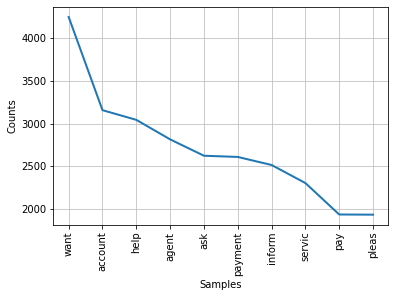

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [3]:
from nltk.probability import FreqDist

fdist = FreqDist(df['words'].sum())
fdist.most_common(3)
fdist.plot(10)

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 1337)

### Count vectorize

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# merged words list
train_words=[' '.join(text) for text in df_train['words']]
test_words=[' '.join(text) for text in df_test['words']]

# count
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(train_words).toarray()
X_test_counts = count_vectorizer.transform(test_words).toarray()

### N-gram

In [18]:
# ngram
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_ng = ngram_vectorizer.fit_transform(train_words).toarray()
X_test_ng = ngram_vectorizer.transform(test_words).toarray()

In [19]:
# tfidf
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False);
X_train_tfidf = transformer.fit_transform(X_train_counts);
X_test_tfidf = transformer.transform(X_test_counts);

In [9]:
# custom word2vec
model_w2v = gensim.models.Word2Vec(sentences=df_train['words'])

In [19]:
# pretrained glove
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = './content/glove.6B.100d.txt'
tmp_file = "./content/glove_100d_word2vec.txt"

_ = glove2word2vec(glove_file, tmp_file)

glove_model = KeyedVectors.load_word2vec_format(tmp_file)


<ipython-input-19-5aa41b271e05>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


KeyboardInterrupt: 

In [20]:
# pretrained bert
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # just needed tensorflow_text

bert_encoder_dir = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
bert_preprocess_dir = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_layer = hub.KerasLayer(bert_preprocess_dir)
bert_encode_model = hub.KerasLayer(bert_encoder_dir, trainable=True)

In [21]:
# tokenized seq for keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['words'])
encoded_train_docs = tokenizer.texts_to_sequences(df_train['words'])
encoded_test_docs = tokenizer.texts_to_sequences(df_test['words'])
max_length = max([len(s) for s in df_train['words']])
X_train = pad_sequences(encoded_train_docs, 
                        maxlen=max_length, 
                        padding='post')
y_train = pd.get_dummies(df_train['category'])
X_test = pad_sequences(encoded_test_docs, 
                        maxlen=max_length, 
                        padding='post')
y_test = pd.get_dummies(df_test['category'])

# Preprocessing Result:
- X_train, X_test: Tokenized doc
- y_train, y_test: taget df
- X_train_tfidf, X_test_tfidf: TFIDF processed df
- X_train_ng, X_test_ng : N-gram embedding DF
- X_train_counts, X_test_counts: Count Vector DF
- model_w2v: CBOW w2v with default parameter
- glove_model : glove embedding
- BERT

In [22]:
import numpy as np

In [23]:
np.save("X_train.npy",X_train)
np.save("X_test.npy",X_test)

In [24]:
df_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

# Colin: Building Supervised Topic Detection Model

In [5]:
import pandas as pd
import numpy as np
import gensim

In [6]:
w2v_pretrain= gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['words'])
encoded_train_docs = tokenizer.texts_to_sequences(df_train['words'])
encoded_test_docs = tokenizer.texts_to_sequences(df_test['words'])
max_length = max([len(s) for s in df_train['words']])
X_train = pad_sequences(encoded_train_docs, 
                        maxlen=max_length, 
                        padding='post')
y_train = pd.get_dummies(df_train['category'])
X_test = pad_sequences(encoded_test_docs, 
                        maxlen=max_length, 
                        padding='post')
y_test = pd.get_dummies(df_test['category'])

In [46]:
# word2vec + cnn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_word2vec_embed_layer(max_length, tokenizer, model):
    word_index = tokenizer.word_index
    embedding_mat = np.zeros((len(word_index)+1, 300))
    for word, i in word_index.items():
        try:
            vector = model.get_vector(word)
            embedding_mat[i] = vector
        except:
            continue
    word2vec_embedding_layer = Embedding(input_dim=embedding_mat.shape[0],
                                      output_dim=embedding_mat.shape[1], 
                                      weights=[embedding_mat],
                                      input_length=max_length, 
                                      trainable=False)
    return word2vec_embedding_layer

embedding = get_word2vec_embed_layer(X_train.shape[1], tokenizer, w2v_pretrain)

# RNN Model for topic detection